#Using ScFv embeddings from Ankh to predict MAPT score.

ScFv embeddings generated by Ankh will be used as features to predict MAPT score with a simple neural network for regression.


In [1]:
#@title Mount drive and load libraries
import os, pandas as pd, numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/notebooks'
os.chdir(path)

from ML_manipulation import standardise, normalise, regression_nn, regression_model2, regression_report

Mounted at /content/drive/


In [2]:
#@title Read in MAPT scores and embeddings
df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230813_human_paired_seqs_MAPT_scores.csv')
l = [pd.read_csv(f'/content/drive/MyDrive/msc-project-mbalmf01/all_paired/{i}') for i in os.listdir('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/') if '230811_human_paired_seqs_MAPT_ankh' in i]
scfv = pd.concat(l)
embeddings = scfv.iloc[:,:-1]
embeddings.shape

(58596, 1536)

In [ ]:
#@markdown Ensure order of seq ids is preserved across all the dataframes.
scfv['seq_id'].to_list() == df['seq_id'].to_list()

True

In [ ]:
#@title Split embeddings into training, validation and testing sets
#extract hydrophobic surfacce values as labels and normalise/standardise for regression
labels = df['MAPSS IgG1 pH7.4'].to_numpy()
labels, min_val, max_val = normalise(labels)
labels, mean_val, std_val = standardise(labels)

X_train = embeddings.iloc[:45000, :]
y_train = labels[:45000]

X_val = embeddings.iloc[45000:, :]
y_val = labels[45000:]

model = regression_nn(input_dim=embeddings.shape[1])

model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
563/563 [==============================] - 10s 16ms/step - loss: 0.4354 - mean_absolute_error: 0.4864 - val_loss: 0.2381 - val_mean_absolute_error: 0.3465
Epoch 2/20
563/563 [==============================] - 6s 11ms/step - loss: 0.2298 - mean_absolute_error: 0.3593 - val_loss: 0.3239 - val_mean_absolute_error: 0.4621
Epoch 3/20
563/563 [==============================] - 8s 15ms/step - loss: 0.2049 - mean_absolute_error: 0.3390 - val_loss: 0.1844 - val_mean_absolute_error: 0.3071
Epoch 4/20
563/563 [==============================] - 6s 11ms/step - loss: 0.1966 - mean_absolute_error: 0.3338 - val_loss: 0.2247 - val_mean_absolute_error: 0.3359
Epoch 5/20
563/563 [==============================] - 8s 15ms/step - loss: 0.1836 - mean_absolute_error: 0.3217 - val_loss: 0.1664 - val_mean_absolute_error: 0.2924
Epoch 6/20
563/563 [==============================] - 7s 12ms/step - loss: 0.1828 - mean_absolute_error: 0.3215 - val_loss: 0.1661 - val_mean_absolute_error: 0.2986
Epoch 7/2

In [ ]:
y_pred = model.predict(X_val)
y_pred = np.array([float(i) for i in y_pred])

report = regression_report(y_val, y_pred)
for key, value in report.items():
    if key != "Residuals":
        print(f"{key}: {round(value, 3)}")
    else:
        print(f"{key} (first 10): {value[:10]}")


425/425 [==============================] - 1s 3ms/step
R^2 Score: 0.868
Mean Absolute Error (MAE): 0.268
Root Mean Squared Error (RMSE): 0.36
Pearson Correlation coefficient: 0.933
Residuals (first 10): [-0.34465068 -0.04459276 -0.50584412 -0.45961916  0.1982046  -0.22617766
 -0.30482844 -0.11460397 -0.08449319  0.31189333]


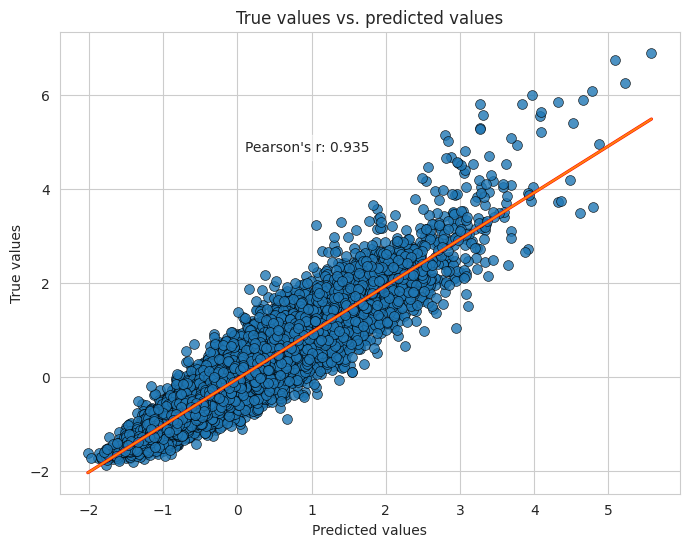

In [ ]:
#@title Plot true vs predicted values
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))

sns.regplot(y=y_val, x=y_pred, scatter_kws={'s': 50, 'edgecolor': 'black', 'linewidth': 0.5}, line_kws={"color": "red"}, ci=None, scatter=True)

#Add titles
plt.title('True values vs. predicted values')
plt.xlabel('Predicted values')
plt.ylabel('True values')

#Fit a line of best fit to the data
coefficients = np.polyfit(y_pred, y_val, 1)  # 1 is the degree of the polynomial (i.e., a straight line)
line_function = np.poly1d(coefficients)
x_line = np.linspace(min(y_pred), max(y_pred), 100)
y_line = line_function(x_line)
plt.plot(x_line, y_line)

#Add Pearson's correlation coefficient
correlation_coefficient, _ = pearsonr(y_val, y_pred)
plt.text(0.1, 4.8, f"Pearson's r: {correlation_coefficient:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.show()

In [ ]:
model = regression_model2(embeddings.shape[1])
#train model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)

Epoch 1/100
141/141 [==============================] - 11s 65ms/step - loss: 2.0530 - mae: 1.0808 - val_loss: 1.2011 - val_mae: 0.7919
Epoch 2/100
141/141 [==============================] - 7s 48ms/step - loss: 0.6882 - mae: 0.6287 - val_loss: 1.0322 - val_mae: 0.7449
Epoch 3/100
141/141 [==============================] - 9s 62ms/step - loss: 0.3503 - mae: 0.4475 - val_loss: 0.7837 - val_mae: 0.6483
Epoch 4/100
141/141 [==============================] - 7s 47ms/step - loss: 0.2645 - mae: 0.3856 - val_loss: 0.4640 - val_mae: 0.5027
Epoch 5/100
141/141 [==============================] - 9s 63ms/step - loss: 0.2353 - mae: 0.3630 - val_loss: 0.2338 - val_mae: 0.3574
Epoch 6/100
141/141 [==============================] - 7s 47ms/step - loss: 0.2152 - mae: 0.3458 - val_loss: 0.2061 - val_mae: 0.3243
Epoch 7/100
141/141 [==============================] - 9s 63ms/step - loss: 0.2064 - mae: 0.3389 - val_loss: 0.1649 - val_mae: 0.2948
Epoch 8/100
141/141 [==============================] - 7s 53m

In [ ]:
y_pred = model.predict(X_val)
y_pred = np.array([float(i) for i in y_pred])

report = regression_report(y_val, y_pred)
for key, value in report.items():
    if key != "Residuals":
        print(f"{key}: {round(value, 3)}")
    else:
        print(f"{key} (first 10): {value[:10]}")

425/425 [==============================] - 3s 7ms/step
R^2 Score: 0.869
Mean Absolute Error (MAE): 0.273
Root Mean Squared Error (RMSE): 0.359
Pearson Correlation coefficient: 0.94
Residuals (first 10): [-0.29422207 -0.04979971 -0.435527   -0.5817837   0.04157683 -0.16059817
 -0.25789932  0.35438958 -0.09890339  0.12337342]


In [3]:
#@title Split embeddings into training, validation and testing sets
#extract hydrophobic surfacce values as labels and normalise/standardise for regression
labels = df['MAPSS IgG1 pH7.4'].to_numpy()
labels, min_val, max_val = normalise(labels)
labels, mean_val, std_val = standardise(labels)

data_split = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 45000]

X_val = embeddings.iloc[45000:, :]
y_val = labels[45000:]

reports = []

for i in data_split:
  X_train = embeddings.iloc[:i, :]
  y_train = labels[:i]
  model = regression_nn(input_dim=embeddings.shape[1])
  model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)
  y_pred = model.predict(X_val)
  y_pred = np.array([float(i) for i in y_pred])
  report = regression_report(y_val, y_pred)
  reports.append(report)


Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.7277 - mean_absolute_error: 0.8151 - val_loss: 0.6827 - val_mean_absolute_error: 0.6648
Epoch 2/20
1/1 [==============================] - 0s 66ms/step - loss: 0.7209 - mean_absolute_error: 0.8102 - val_loss: 0.6544 - val_mean_absolute_error: 0.6431
Epoch 3/20
1/1 [==============================] - 0s 61ms/step - loss: 0.7138 - mean_absolute_error: 0.8028 - val_loss: 0.6158 - val_mean_absolute_error: 0.6134
Epoch 4/20
1/1 [==============================] - 0s 70ms/step - loss: 0.7065 - mean_absolute_error: 0.7932 - val_loss: 0.5873 - val_mean_absolute_error: 0.5898
Epoch 5/20
1/1 [==============================] - 0s 74ms/step - loss: 0.7135 - mean_absolute_error: 0.7949 - val_loss: 0.5679 - val_mean_absolute_error: 0.5731
Epoch 6/20
1/1 [==============================] - 0s 57ms/step - loss: 0.6818 - mean_absolute_error: 0.7722 - val_loss: 0.5477 - val_mean_absolute_error: 0.5552
Epoch 7/20
1/1 [====================

In [4]:
import pprint as pp
r2 = []
mae = []
rmse = []
corr = []
for report in reports:
  r2.append(report['R^2 Score'])
  mae.append(report['Mean Absolute Error (MAE)'])
  rmse.append(report['Root Mean Squared Error (RMSE)'])
  corr.append(report['Pearson Correlation coefficient'])
  pp.pprint(report['R^2 Score'])

-0.013077084250205706
-0.15065593463839777
-0.010106474509480323
-0.030427339086974703
0.10408892149209792
0.38018893926165964
0.6271152996714323
0.7347519359081898
0.8097262318135541
0.8292441089490881
0.8428807185868918
0.8569057339882019
0.8366923770190411
0.8621750389470006


In [5]:
RMSE_max = max(rmse)
MAE_max = max(mae) + 1

rmse_norm = [rms / RMSE_max for rms in rmse]
mae_norm = [ma / MAE_max for ma in mae]

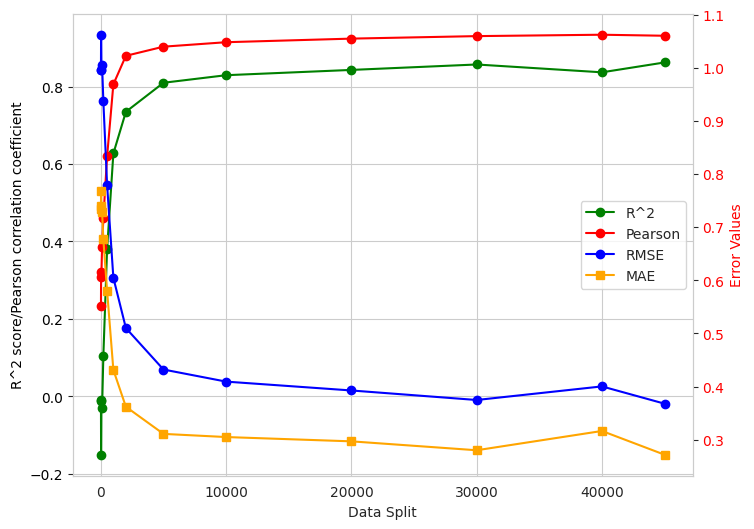

In [16]:
#@title Create figure of regression model parameters
fig, ax1 = plt.subplots(figsize=(8, 6))

#Plot data on first y-axis
line1, = ax1.plot(data_split, r2, '-o', color='green', label='R^2')
line2, = ax1.plot(data_split, corr, '-o', color='red', label='Pearson')

ax1.set_xlabel('Data Split')
ax1.set_ylabel('R^2 score/Pearson correlation coefficient', color='black')
ax1.tick_params(axis='y', labelcolor='black')

#link two data
ax2 = ax1.twinx()

# Plotting data on the second y-axis
line3, = ax2.plot(data_split, rmse, '-o', color='blue', label='RMSE')
line4, = ax2.plot(data_split, mae, '-s', color='orange', label='MAE')
ax2.set_ylabel('Error Values', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combining legends into one box
lines = [line1, line2, line3, line4]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

plt.grid(False)
plt.show()
